# Some tests with Symmetric Cryptography

In [1]:
# Some imports
from os import urandom
from binascii import hexlify as hexa
import time
import collections
import numpy as np
import matplotlib.pyplot as plt

from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

## Example 1
We will encrypt a single block of data using AES in ECB mode

In [5]:
# set plaintext block p to the all-zero string
p = b'\x00'*16
print("p = {}".format(hexa(p)))

p = b'00000000000000000000000000000000'


In [6]:
# pick a random 16-byte key using Python's crypto PRNG
k = urandom(16)
print("k = {}".format(hexa(k)))

k = b'dbb977e75e01cb215488bed7acf4574f'


In [7]:
# create an instance of AES-128 to encrypt a single block
cipher = Cipher(algorithms.AES(k), modes.ECB(), backend = default_backend())

In [8]:
# encrypt plaintext p to ciphertext c
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()
print ("enc({}) = {}".format(hexa(p), hexa(c)))

enc(b'00000000000000000000000000000000') = b'e1306b93f4b38b8d541277f3642d5a97'


In [9]:
# decrypt ciphertext c to plaintext p
aes_decrypt = cipher.decryptor()
p = aes_decrypt.update(c) + aes_decrypt.finalize()
print("dec({}) = {}".format(hexa(c), hexa(p)))

dec(b'e1306b93f4b38b8d541277f3642d5a97') = b'00000000000000000000000000000000'


## Example 2
We encrypt two identical blocks with ECB and see that their encryption is the same

In [32]:
# block size is 16 bytes
BLOCKLEN = 16

In [11]:
# a function that pretty prints the plaintext into blocks
def blocks(data):
    split = [hexa(data[i:i+BLOCKLEN]) for i in range(0, len(data), BLOCKLEN)]
    return b' '.join(split)

In [12]:
# set plaintext block p to the all-zero string
p = b'\x00'*BLOCKLEN*2
print("p = {}".format(hexa(p)))

p = b'0000000000000000000000000000000000000000000000000000000000000000'


In [13]:
# pick a random 16-byte key using Python's crypto PRNG
k = urandom(16)
print("k = {}".format(hexa(k)))

k = b'198b3c5207bc087e99933b444237a13c'


In [14]:
# create an instance of AES-128 to encrypt and decrypt
cipher = Cipher(algorithms.AES(k), modes.ECB(), backend=default_backend())

In [15]:
# encrypt plaintext p to ciphertext c
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()
print("enc({}) =\n    {}".format(blocks(p), blocks(c)))

enc(b'00000000000000000000000000000000 00000000000000000000000000000000') =
    b'0a42c698fa3cb6487329eba8ec673ece 0a42c698fa3cb6487329eba8ec673ece'


## Example 3
We encrypt the Linux mascot with ecb, and see that patterns get through. According to Marsh Ray,
> "ECB cannot be used because you can see the penguin"

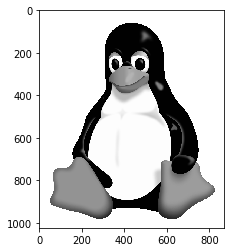

In [23]:
# Load the penguin image
tux = plt.imread('tux_gray.png')
plt.imshow(tux)
plt.show()

In [24]:
# Keep only luminance and serialize the image
# The plaintext is a string of bytes
tux = tux[:,:,1] * 255
tux = tux.astype(np.uint8)
p = tux.tobytes()

In [25]:
# Generate a key and an instance of AES
k = urandom(16)
cipher = Cipher(algorithms.AES(k), modes.ECB(), backend=default_backend())

In [26]:
# Encrypt the image
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()

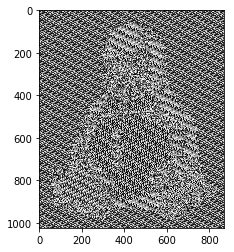

In [27]:
# Reshape the ciphertext into a matrix of bytes 
# Show the ciphertext
encrypted_tux = np.frombuffer(c, dtype = np.uint8).reshape(tux.shape)

plt.imshow(encrypted_tux,cmap='gray')
plt.show()

## Example 4
We encrypt the Linux mascot with deterministic CTR, and see that patterns disappear.

In [28]:
# Serialize the image
# The plaintext is a string of bytes
p = tux.tobytes()

In [33]:
# block size is 16 bytes
BLOCKLEN = 16

In [34]:
# Generate a key and an instance of AES
k = urandom(16)

In [35]:
# Generate the starting counter (in deterministic CTR, we start from 0)
iv = b'\x00'*BLOCKLEN

In [36]:
# Generate an instance of AES with the given key and nonce
cipher = Cipher(algorithms.AES(k), modes.CTR(iv), backend=default_backend())

In [37]:
# Encrypt the image
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()

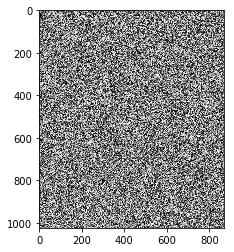

In [39]:
# Reshape the ciphertext into a matrix of bytes 
# Show the ciphertext
encrypted_tux = np.frombuffer(c, dtype = np.uint8).reshape(tux.shape)

plt.imshow(encrypted_tux,cmap='gray')
plt.show()

## Example 5
We generate a new ciphertext with the same key and still use deterministic CTR.
We then see that we can then learn about the plaintext 

In [53]:
# Load "The Black Cat" by Edgar Allan Poe 
with open('cat.txt', 'rb') as myfile:
    cat=myfile.read()

# The file is shorter than the image, so we make it the same size
plaintext_cat = 50 * cat
plaintext_cat = plaintext_cat[0:len(p)]

In [54]:
# Encrypt the text with the same key and IV
cipher = Cipher(algorithms.AES(k), modes.CTR(iv), backend=default_backend())
aes_encrypt = cipher.encryptor()
encrypted_cat = aes_encrypt.update(plaintext_cat) + aes_encrypt.finalize()

In [55]:
# Reshape the encripted poem into a matrix
encrypted_cat = np.frombuffer(encrypted_cat, dtype = np.uint8).reshape(tux.shape)

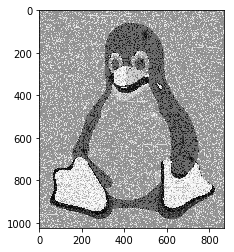

In [56]:
# Calculate the XOR between the ciphertexts
ciphertext_xor = np.bitwise_xor(encrypted_cat, encrypted_tux)

plt.imshow(ciphertext_xor,cmap='gray')
plt.show()

----
## Example 6
We look at RC4 bias. It is known that the second byte of the keystream is twice more likely to be zero.

In [61]:
# Generate a random plaintext
p = urandom(16)

In [62]:
# Now encrypt the plaintext with several different keys and collect the second byte
second_byte_of_c = []
for i in range(10000):
    # Generate a random key
    k = urandom(8)
    # Generate an instance of RC4
    cipher = Cipher(algorithms.ARC4(k), None, backend=default_backend())
    # Perform encryption
    rc4_encrypt = cipher.encryptor()
    c = rc4_encrypt.update(p) + rc4_encrypt.finalize()
    # Save the second byte
    second_byte_of_c.append(c[1])

In [63]:
# Count the number of times each value appears
# The most popular value appears almost twice as often as the second one
collections.Counter(second_byte_of_c).most_common(5)

[(22, 85), (82, 58), (70, 56), (4, 54), (184, 52)]

In [64]:
# Compare to the second character in the plaintext 
p[1]

22

----
## Example 7
Compare the speed of AES and Chacha20

In [91]:
# Generate a large plaintext
p = urandom(2**22)

In [92]:
# Instantiate AES with random key and nonce
k = urandom(16)
nonce = urandom(16)
cipher = Cipher(algorithms.AES(k), modes.CTR(nonce), backend=default_backend())
aes_encrypt = cipher.encryptor()

In [93]:
start = time.time()
c = aes_encrypt.update(p) + aes_encrypt.finalize()
end = time.time()
print(end-start)

0.03510332107543945


In [94]:
# Instantiate Chacha20 with random key and nonce
k = urandom(32)
nonce = urandom(16)
cipher = Cipher(algorithms.ChaCha20(k,nonce), None, backend=default_backend())
chacha_encrypt = cipher.encryptor()

In [95]:
start = time.time()
c = chacha_encrypt.update(p) + chacha_encrypt.finalize()
end = time.time()
print(end-start)

0.14016389846801758


-------
# Example 8
We encrypt the same message with Chacha20 and different nonces and look at the hamming distance.
We should see that about half of the bits are ones

In [102]:
# Generate a random plaintext and key
message_size = 2**10
p = urandom(message_size)
k = urandom(32)

In [103]:
# Encrypt with first nonce
nonce = urandom(16)
cipher = Cipher(algorithms.ChaCha20(k,nonce), None, backend=default_backend())
chacha_encrypt = cipher.encryptor()
c1 = chacha_encrypt.update(p) + chacha_encrypt.finalize()

In [104]:
# Encrypt with second nonce
nonce = urandom(16)
cipher = Cipher(algorithms.ChaCha20(k,nonce), None, backend=default_backend())
chacha_encrypt = cipher.encryptor()
c2 = chacha_encrypt.update(p) + chacha_encrypt.finalize()

In [105]:
# Find what bits are different in the two encryptions
difference = np.bitwise_xor(
    np.frombuffer(c1, dtype = np.uint8),
    np.frombuffer(c2, dtype = np.uint8)
)

In [106]:
# Count the number of ones
ones = ''.join(map(bin,difference)).count('1')

In [107]:
print("Total number of bits is {}, number of ones is {}".format(message_size*8,ones))

Total number of bits is 8192, number of ones is 4106
